# MVP for EDA project

This is a Minimum Viable Project for the EDA course.
In this project, our customer is WTWY international, who want to support inclusion of women in technology fields as well as build awareness and contacts for the organisation.
WTWY has a summar gala in NYC and would like to get more people to attend it to support the above goals, ideally people who will attend and contribute

WTWY has decided to place street teams at subway stations to collect signatures + email addresses in order to send free tickets, and would like to utilize our teams data analytics expertise in order to make the next annual gala a resounding success

<u>*Tips*</u>:

1. I might have put a bit too much in this notebook. To make it easier to navigate, I added a TOC
2. Use TOC to jump around, use the `<Home>` key to go back to TOC

## Table of Contents:
<b id="top">TOC</b>
* [Goals](#goals)
* [Preliminary Analysis](#preliminary_analysis)
 * [Sidenote 1](#sidenote_1)
* [Experiment 1](#experiment_1)
* [Solution](#solution)
 * [Check for duplicates](#check_duplicates)
 * [Sort by station and turnstile](#sort)
 * [Calculate exit delta](#calc_delta)
 * [Filter exit delta](#filter_delta)
 * [Aggregate exit delta](#aggregate_delta)
* [Conclusion](#conclusion)
 * [Busiest stations](#busy_station)
 * [Busiest times](#busy_time)
 * [Sidenote 2](#sidenote_2)

<!--## Goals<a class="anchor" id="goals"></a> -->
<span style="font-size:2em"><b id="goals">Goals</b></span> <a href="#top">[back to top]</a>

The goals for this MVP are as follows:
1. Gather and sort through statistics for subway station data and pick up to 5 stations with the highest foot traffic
2. Analyse the trend for these stations, going up, going down? busiest times during the day, busiest time during the year
3. Recommend the stations that will be the best places for street teams as well as the best times

### Stretch target
1. WTWY would like to widen the reach of their organisation as well as get more people to contribute. A possible second source of data could be average net worth/salaries in a neighborhood, since a high average net worth/income indicates more disposable income and thus more likeliness to donate


<!-- ## Preliminary Analysis:<a class="anchor" id="preliminary_analysis"></a> -->
<span style="font-size:2em"><b id="preliminary_analysis">Preliminary Analysis</b></span> <a href="#top">[back to top]</a>

### Importing the data

For this project, data is collected from MTA turnstile data at http://web.mta.info/developers/turnstile.html
A convenience script (get_mta.py) is used to collect every weeks data for the year 2021, and load that into sqlite3 database mta_data.db

In [1]:
import pandas as pd
import sqlite3

con = sqlite3.connect("mta_data.db")
mta_data = pd.read_sql_query("SELECT * from mta_data", con)

In [2]:
mta_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,00:00:00,REGULAR,7611181,2603110
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,04:00:00,REGULAR,7611192,2603113
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,08:00:00,REGULAR,7611197,2603126
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,12:00:00,REGULAR,7611235,2603178
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,16:00:00,REGULAR,7611357,2603211


In [3]:
mta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6697551 entries, 0 to 6697550
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 562.1+ MB


In [4]:
mta_data.describe()

,ENTRIES,EXITS
count,6.697551e+06,6.697551e+06
mean,4.201677e+07,3.372964e+07
std,2.187455e+08,1.936177e+08
min,0.000000e+00,0.000000e+00
25%,2.204835e+05,9.477600e+04
50%,1.462864e+06,8.780630e+05
75%,6.135574e+06,4.034225e+06
max,2.147432e+09,2.123073e+09


In [5]:
mta_data.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [6]:
mta_data.isna().sum()

C/A         0
UNIT        0
SCP         0
STATION     0
LINENAME    0
DIVISION    0
DATE        0
TIME        0
DESC        0
ENTRIES     0
EXITS       0
dtype: int64

In [7]:
mta_data.shape

(6697551, 11)

### Observation:

1. Date and time are string, and will have to be converted.
2. Entries and exits were imported as int correctly, and are the only numerical data
3. No NaN values for entries or exits. Number of observations is 6.69 M
4. There is a very large range for both entries and exits. [ 0, 2.147 * 10^9 ] for entries. 
   Also relevant are the quartiles. The numbers are pretty similar, so lets just look at entries. median is 1.4 *    10^6, mean is 4.2 * 10^7 , which are both less than half of the range, indicating right skewness. So, majority
   of the numbers for entries are large, and there may be few small values.
   
From the first 5 rows above, the counters seem to be accumulating, and from above conclusion there is a chance that some counters have either reset or rolled over to start from minimum. Best case would be if the counters have reset at the beginning of our observations

### Re-labelling

Change the column indices to lower case to make it easy to work with

In [8]:
mta_data.rename(columns=lambda x:x.strip().lower().replace('/','_'), inplace=True)
mta_data.columns

Index(['c_a', 'unit', 'scp', 'station', 'linename', 'division', 'date', 'time',
       'desc', 'entries', 'exits'],
      dtype='object')

In [9]:
mta_data.head()

,c_a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,00:00:00,REGULAR,7611181,2603110
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,04:00:00,REGULAR,7611192,2603113
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,08:00:00,REGULAR,7611197,2603126
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,12:00:00,REGULAR,7611235,2603178
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,16:00:00,REGULAR,7611357,2603211


### Fix incorrect data types

Dates and times are string, need to be converted to proper pandas datetime stamps.
Here we drop the time column, since the timestamp column is more useful.

In [10]:
mta_data['datetime'] = pd.to_datetime(mta_data['date'] + ' ' + mta_data['time'])
mta_data['date'] = pd.to_datetime(mta_data['date'])
mta_data.drop('time', axis=1, inplace=True)

### Placeholder - Point of no return

From this point on, its unsafe to go back up, since we changed a column's ('date') data type, and dropped an
<br>unnecessary column ('time')

In [11]:
mta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6697551 entries, 0 to 6697550
Data columns (total 11 columns):
 #   Column    Dtype         
---  ------    -----         
 0   c_a       object        
 1   unit      object        
 2   scp       object        
 3   station   object        
 4   linename  object        
 5   division  object        
 6   date      datetime64[ns]
 7   desc      object        
 8   entries   int64         
 9   exits     int64         
 10  datetime  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 562.1+ MB


<!-- ### Sidenote 1:<a class="anchor" id="sidenote_1"></a> -->
<span style="font-size:1.5em"><b id="sidenote_1">Sidenote 1</b></span> <a href="#top">[back to top]</a>

What is not clear from the data is the relationship between station, c_a, unit and scp.
station is obviously unique per NYC subway station.
From the discussion in https://groups.google.com/g/mtadeveloperresources/c/z8l3ZU9cY6Y/m/OFlHGkFAimQJ and https://data.ny.gov/Transportation/Turnstile-Usage-Data-2020/py8k-a8wg, scp could be one or more turnstiles. So what are unit and c_a? Lets investigate by grouping by stations

In [14]:
temp = mta_data.groupby(['station'])[['unit', 'c_a', 'scp']].nunique()
temp.max()

unit     6
c_a     13
scp     80
dtype: int64

Here we see that there seems to be a rough hierarchy among unit , c_a and scp (unit < c_a < scp)
So, one station can have multiple units, each of which may have multiple control areas, and each of those may have multiple turnstiles
This may not be useful in further analysis, but at least it hints at an order to the data
It may also be theorized that a station with the largest no. of scp's should be one of the largest stations, and maybe subject to the most foot traffic

In [15]:
temp.sort_values('scp',ascending=False)[:3]

,unit,c_a,scp
station,,,
FULTON ST,3,12,80
34 ST-PENN STA,4,13,63
GRD CNTRL-42 ST,4,8,53


In [16]:
temp = None
# Dont need this anymore, so release memory when convenient

### Unique turnstile id

For the rest of the analysis from here on, we can consider a combination of unit, c_a and scp to be one unique turnstile. So, for a station like 'WALL ST', to get the total number of people exiting, we would need to add up the people exiting at each unique turnstile that belongs to that station

In [17]:
mta_data['turnstile_id'] = mta_data['unit'] + '_' + mta_data['c_a'] + '_' + mta_data['scp']

In [18]:
mta_data.head()

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-07-31,REGULAR,7611181,2603110,2021-07-31 00:00:00,R051_A002_02-00-00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-07-31,REGULAR,7611192,2603113,2021-07-31 04:00:00,R051_A002_02-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-07-31,REGULAR,7611197,2603126,2021-07-31 08:00:00,R051_A002_02-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-07-31,REGULAR,7611235,2603178,2021-07-31 12:00:00,R051_A002_02-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-07-31,REGULAR,7611357,2603211,2021-07-31 16:00:00,R051_A002_02-00-00


<!-- ## Experiment 1:<a class="anchor" id="experiment_1"></a> -->
<span style="font-size:2em"><b id="experiment_1">Experiment 1</b></span> <a href="#top">[back to top]</a>


<br>Lets explore data just for one station - the one that showed up on top, just after import - 59 ST.
We will attempt to find the number of people exiting the station for all of 2021.

Q: Why such a large range of dates for 2021 and station 59 ST ?

A: This is an experiment, just to check data ordering and consistency. Usually problems in data show up with large ranges

Q: Why not consider entry?

A: WTWY's volunteers wont be purchasing tickets, so they wont be within the turnstile, besides, for people entering the turnstile, they're probably in a hurry to catch their train

Q: Why not consider total people within the station i.e. entry - exit

A: The volunteers would need to purchase a ticket to be within the station. Usually theres rules for such stations probiting any solicitation. It'll be easier to keep a count of the exits, since people coming out of trains are usually more likely to have a few minutes to spend, so our volunteers can talk to them

In [19]:
temp = mta_data[(mta_data.station == '59 ST')].copy()

To find the total number of people exiting 59 ST station, we will have to group by turnstile, using our unique turnstile id. We create a column called delta, which has the difference between current entry and previous

In [20]:
temp.sort_values(['turnstile_id', 'datetime'], inplace=True)
temp.head()

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id
6653205,R244A,R050,01-00-00,59 ST,456NQRW,IRT,2020-12-26,REGULAR,4926503,19829155,2020-12-26 03:00:00,R050_R244A_01-00-00
6653206,R244A,R050,01-00-00,59 ST,456NQRW,IRT,2020-12-26,REGULAR,4926503,19829165,2020-12-26 07:00:00,R050_R244A_01-00-00
6653207,R244A,R050,01-00-00,59 ST,456NQRW,IRT,2020-12-26,REGULAR,4926506,19829186,2020-12-26 11:00:00,R050_R244A_01-00-00
6653208,R244A,R050,01-00-00,59 ST,456NQRW,IRT,2020-12-26,REGULAR,4926513,19829220,2020-12-26 15:00:00,R050_R244A_01-00-00
6653209,R244A,R050,01-00-00,59 ST,456NQRW,IRT,2020-12-26,REGULAR,4926531,19829255,2020-12-26 19:00:00,R050_R244A_01-00-00


In [21]:
temp.shape

(75320, 12)

Now, lets check for duplicates.
<br>First what would be a duplicate? 
<br>For station 59 ST, we would define a duplicate as having the
<br>same turnstile id, and the same exact datetime

In [22]:
num_dups = temp[temp.duplicated(subset=['station', 'turnstile_id', 'datetime'])].shape[0]
print("There are %d duplicates" % num_dups)

There are 0 duplicates


There are zero duplicates for 59 ST, so we can proceed with further analysis

In [23]:
temp['delta'] = temp.groupby('turnstile_id').exits.transform(lambda x: x.diff())
temp.head()

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id,delta
6653205,R244A,R050,01-00-00,59 ST,456NQRW,IRT,2020-12-26,REGULAR,4926503,19829155,2020-12-26 03:00:00,R050_R244A_01-00-00,NaN
6653206,R244A,R050,01-00-00,59 ST,456NQRW,IRT,2020-12-26,REGULAR,4926503,19829165,2020-12-26 07:00:00,R050_R244A_01-00-00,10.0
6653207,R244A,R050,01-00-00,59 ST,456NQRW,IRT,2020-12-26,REGULAR,4926506,19829186,2020-12-26 11:00:00,R050_R244A_01-00-00,21.0
6653208,R244A,R050,01-00-00,59 ST,456NQRW,IRT,2020-12-26,REGULAR,4926513,19829220,2020-12-26 15:00:00,R050_R244A_01-00-00,34.0
6653209,R244A,R050,01-00-00,59 ST,456NQRW,IRT,2020-12-26,REGULAR,4926531,19829255,2020-12-26 19:00:00,R050_R244A_01-00-00,35.0


In [24]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75320 entries, 6653205 to 24117
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   c_a           75320 non-null  object        
 1   unit          75320 non-null  object        
 2   scp           75320 non-null  object        
 3   station       75320 non-null  object        
 4   linename      75320 non-null  object        
 5   division      75320 non-null  object        
 6   date          75320 non-null  datetime64[ns]
 7   desc          75320 non-null  object        
 8   entries       75320 non-null  int64         
 9   exits         75320 non-null  int64         
 10  datetime      75320 non-null  datetime64[ns]
 11  turnstile_id  75320 non-null  object        
 12  delta         75264 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(8)
memory usage: 8.0+ MB


In [25]:
temp['delta'].describe()

count    7.526400e+04
mean    -5.890545e+01
std      3.235048e+04
min     -8.869850e+06
25%      8.000000e+00
50%      3.200000e+01
75%      9.000000e+01
max      1.011000e+03
Name: delta, dtype: float64

Oops!
Theres a problem, minimum is -8.86 * 10^6. Thats a very large negative, implying that the previous entry was an extremely large number. Did we just see a rollover? 
Lets check the first 5 such rows

In [26]:
temp.sort_values('delta')[:5]

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id,delta
3977908,A002,R051,02-03-02,59 ST,NQR456W,BMT,2021-03-22,REGULAR,22,8,2021-03-22 16:00:00,R051_A002_02-03-02,-8869850.0
3095647,R244,R050,00-00-03,59 ST,456NQRW,IRT,2021-04-25,REGULAR,11,3,2021-04-25 00:00:00,R050_R244_00-00-03,-293081.0
6232432,R245,R051,00-00-00,59 ST,456NQRW,IRT,2021-01-15,REGULAR,47,21,2021-01-15 15:00:00,R051_R245_00-00-00,-76819.0
793992,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-14,REGULAR,1040923917,734763129,2021-07-14 12:00:00,R051_R245_00-03-02,-441.0
375104,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-29,REGULAR,1040926161,734747422,2021-07-29 12:00:00,R051_R245_00-03-02,-396.0


The first 3 rows seem to indicate a rollover, given the small number in exits columns. The last 3 merit further investigation. They seem to be for the same turnstile - c_a: R245A, unit R051, scp 01-00-02.
First, lets check the first and second rows for a rollover

In [27]:
temp[
    (temp.turnstile_id == 'R051_A002_02-03-02')
    & (temp.date == '2021-03-22')
]

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id,delta
3977904,A002,R051,02-03-02,59 ST,NQR456W,BMT,2021-03-22,REGULAR,6641438,8869481,2021-03-22 00:00:00,R051_A002_02-03-02,25.0
3977905,A002,R051,02-03-02,59 ST,NQR456W,BMT,2021-03-22,REGULAR,6641440,8869486,2021-03-22 04:00:00,R051_A002_02-03-02,5.0
3977906,A002,R051,02-03-02,59 ST,NQR456W,BMT,2021-03-22,REGULAR,6641446,8869630,2021-03-22 08:00:00,R051_A002_02-03-02,144.0
3977907,A002,R051,02-03-02,59 ST,NQR456W,BMT,2021-03-22,REGULAR,6641481,8869858,2021-03-22 12:00:00,R051_A002_02-03-02,228.0
3977908,A002,R051,02-03-02,59 ST,NQR456W,BMT,2021-03-22,REGULAR,22,8,2021-03-22 16:00:00,R051_A002_02-03-02,-8869850.0
3977909,A002,R051,02-03-02,59 ST,NQR456W,BMT,2021-03-22,REGULAR,238,88,2021-03-22 20:00:00,R051_A002_02-03-02,80.0


In [28]:
temp[
    (temp.turnstile_id == 'R051_R245_00-00-00')
    & (temp.date == '2021-01-15')
]

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id,delta
6232429,R245,R051,00-00-00,59 ST,456NQRW,IRT,2021-01-15,REGULAR,261134,76804,2021-01-15 03:00:00,R051_R245_00-00-00,3.0
6232430,R245,R051,00-00-00,59 ST,456NQRW,IRT,2021-01-15,REGULAR,261134,76811,2021-01-15 07:00:00,R051_R245_00-00-00,7.0
6232431,R245,R051,00-00-00,59 ST,456NQRW,IRT,2021-01-15,REGULAR,261148,76840,2021-01-15 11:00:00,R051_R245_00-00-00,29.0
6232432,R245,R051,00-00-00,59 ST,456NQRW,IRT,2021-01-15,REGULAR,47,21,2021-01-15 15:00:00,R051_R245_00-00-00,-76819.0
6232433,R245,R051,00-00-00,59 ST,456NQRW,IRT,2021-01-15,REGULAR,260,64,2021-01-15 19:00:00,R051_R245_00-00-00,43.0
6232434,R245,R051,00-00-00,59 ST,456NQRW,IRT,2021-01-15,REGULAR,366,79,2021-01-15 23:00:00,R051_R245_00-00-00,15.0


Yup!, Its a **rollover**, but strange enough, there doesnt seem to be a common number.
<br>This indicates that each turnstile may have a different counter limit, so we can't just rely on a certain
<br>large number to indicate that a rollover is about to happen...

Ok, what about the other observations for turnstile R051_R245A_01-00-02 ?
<br>Lets take a look...

In [29]:
temp[
    (temp.turnstile_id == 'R051_R245_00-03-02')
    & (temp.datetime >= '2021-07-13 04:00:00')
    & (temp.datetime <= '2021-07-14 19:00:00')
].sort_values('datetime')

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id,delta
793984,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-13,REGULAR,1040923720,734764902,2021-07-13 04:00:00,R051_R245_00-03-02,-7.0
793985,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-13,REGULAR,1040923731,734764732,2021-07-13 08:00:00,R051_R245_00-03-02,-170.0
793986,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-13,REGULAR,1040923759,734764336,2021-07-13 12:00:00,R051_R245_00-03-02,-396.0
793987,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-13,REGULAR,1040923801,734764090,2021-07-13 16:00:00,R051_R245_00-03-02,-246.0
793988,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-13,REGULAR,1040923878,734763832,2021-07-13 20:00:00,R051_R245_00-03-02,-258.0
793989,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-14,REGULAR,1040923893,734763742,2021-07-14 00:00:00,R051_R245_00-03-02,-90.0
793990,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-14,REGULAR,1040923895,734763731,2021-07-14 04:00:00,R051_R245_00-03-02,-11.0
793991,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-14,REGULAR,1040923904,734763570,2021-07-14 08:00:00,R051_R245_00-03-02,-161.0
793992,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-14,REGULAR,1040923917,734763129,2021-07-14 12:00:00,R051_R245_00-03-02,-441.0
793993,R245,R051,00-03-02,59 ST,456NQRW,IRT,2021-07-14,REGULAR,1040923958,734762863,2021-07-14 16:00:00,R051_R245_00-03-02,-266.0


Huh??
<br>This counter is actually counting *backwards*?
<br>exit on date 2021-07-13, time 04:00:00 is 734764902, and at 8am, thats 734764732 , which is less that 734764902...
<br>But the entries are increasing?

In [30]:
def_mask = (temp.delta < 0) & (temp.exits > 30)
num_def = temp[def_mask]['turnstile_id'].nunique()
print("Number of defective turnstiles: %d" % num_def)
bad_turnstile = temp[(temp.delta < 0) & (temp.exits > 30)]['turnstile_id'].value_counts().index.values[num_def-1]
print("Defective turnstile : %s" % bad_turnstile)

Number of defective turnstiles: 1
Defective turnstile : R051_R245_00-03-02


In [31]:
print(temp[(temp.turnstile_id == bad_turnstile) & (temp.delta < 0)]['datetime'].max())
print(temp[(temp.turnstile_id == bad_turnstile) & (temp.delta < 0)]['datetime'].min())

2021-08-06 20:00:00
2020-12-26 07:00:00


This seems to be a problem with just one turnstile on station 59 ST. And it seems to have been counting in reverse for the whole of 2021!
Someone should probably inform MTA...

Meanwhile, for our analysis, we have concluded that it is best to discard negative deltas since they are either:
1. A rollover event, in which case, the previous entry is invalid for a delta
2. A defective counter, in which case, we cannot really trust any counts.

Any other problems? How about extremely large values?

In [32]:
num_huge_delta = temp[temp.delta > 14400].shape[0]
print("There are %d rows with delta values that are too large" % num_huge_delta)

There are 0 rows with delta values that are too large


### Experiment 1 - Conclusion:

1. To find the total number of people exiting the station, we successfully calculate a delta value as the    
   difference between current exit counter and previous
2. We did find negative values, which were for 2 reasons:
   
   a. Defective counter
   <br>b. Rollover
   
   In both cases, our recommendation is to discard observations with negative delta

In [33]:
temp = None
# Release memory, experiment concluded

<!-- ## Solution:<a class="anchor" id="solution"></a> -->
<span style="font-size:2em"><b id="solution">Solution</b></span> <a href="#top">[back to top]</a>

<br>Lets find the top stations, just for past 90 days. The following steps need to be completed:
1. We will first check for duplicates
2. Before calculating the difference of exit entries, we will need to sort by turnstile id and date, so we are     
   taking delta from correct entries.
3. Calculate difference in exit numbers while grouping by station and turnstile, to avoid taking difference
   between different stations.
4. We will need to discard negative deltas, and/or any extreme values, 
   and then add up exit delta's per station
5. Aggregate exit delta per station and find the top 5 highest traffic stations. Scatter/lineplot these

<!-- ### 1. Check for duplicates<a class="anchor" id="check_duplicates"></a> -->
<span style="font-size:1.5em"><b id="check_duplicates">1. Check for duplicates</b></span> <a href="#top">[back to top]</a>

In [127]:
from pandas import Timedelta as td
day_end = mta_data.datetime.max()
day_start = mta_data.datetime.max() - td(90, unit='days')
print("This duration starts at {}, and ends at {}".format(day_start, day_end))

This duration starts at 2021-05-08 23:57:50, and ends at 2021-08-06 23:57:50


In [128]:
temp=None
temp = mta_data[(mta_data.datetime >= day_start) & (mta_data.datetime <= day_end)].copy()
temp.head()

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-07-31,REGULAR,7611181,2603110,2021-07-31 00:00:00,R051_A002_02-00-00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-07-31,REGULAR,7611192,2603113,2021-07-31 04:00:00,R051_A002_02-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-07-31,REGULAR,7611197,2603126,2021-07-31 08:00:00,R051_A002_02-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-07-31,REGULAR,7611235,2603178,2021-07-31 12:00:00,R051_A002_02-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-07-31,REGULAR,7611357,2603211,2021-07-31 16:00:00,R051_A002_02-00-00


In [129]:
temp.shape

(2692324, 12)

Lets check for duplicates again:

In [130]:
num_dups = temp[temp.duplicated(subset=['station', 'turnstile_id', 'datetime'])].shape[0]
print("There are %d duplicates" % num_dups)

There are 12 duplicates


12 dupes!
Lets have a look:

In [131]:
dupes = temp[temp.duplicated(subset = ['station','turnstile_id','datetime'])]
dupes

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id
607345,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-22,RECOVR AUD,262243,0,2021-07-22 00:00:00,R094_R514_00-05-00
607347,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-22,RECOVR AUD,262243,0,2021-07-22 04:00:00,R094_R514_00-05-00
607351,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-22,RECOVR AUD,262243,0,2021-07-22 08:00:00,R094_R514_00-05-00
607353,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-22,RECOVR AUD,262243,0,2021-07-22 12:00:00,R094_R514_00-05-00
1334238,N213,R154,00-00-00,TREMONT AV,BD,IND,2021-06-23,RECOVR AUD,3682482,2760115,2021-06-23 05:00:00,R154_N213_00-00-00
1334449,N213,R154,00-00-05,TREMONT AV,BD,IND,2021-06-23,RECOVR AUD,369307075,100833056,2021-06-23 05:00:00,R154_N213_00-00-05
1347389,N335,R158,01-00-03,KEW GARDENS,EF,IND,2021-06-20,RECOVR AUD,5201960,17258853,2021-06-20 18:30:00,R158_N335_01-00-03
1347432,N335,R158,01-00-04,KEW GARDENS,EF,IND,2021-06-20,RECOVR AUD,6718777,26526664,2021-06-20 18:30:00,R158_N335_01-00-04
1347893,N336,R158,00-00-05,KEW GARDENS,EF,IND,2021-06-20,RECOVR AUD,8833758,2334263,2021-06-20 18:30:00,R158_N336_00-00-05
2270855,R314,R406,00-00-02,PROSPECT AV,25,IRT,2021-05-28,RECOVR AUD,67258361,16839157,2021-05-28 05:00:00,R406_R314_00-00-02


Lets have a look at why the values were duplicated:

In [132]:

LIMIT = 12
counter = 0

for ix,k in dupes.iterrows():
    print('===================Duplicate %d===================' % counter)
    print(temp[(temp.station == k.station) 
               & (temp.turnstile_id == k.turnstile_id) 
               & (temp.datetime == k.datetime)])
    print('==================================================\n')
    counter += 1
    if counter > LIMIT:
        print("Reached limit of %d, terminating...." % LIMIT)
        break

===================Duplicate 0===================
         c_a  unit       scp       station linename division       date  \
607344  R514  R094  00-05-00  ASTORIA BLVD      NQW      BMT 2021-07-22   
607345  R514  R094  00-05-00  ASTORIA BLVD      NQW      BMT 2021-07-22   

              desc  entries  exits   datetime        turnstile_id  
607344     REGULAR        3      0 2021-07-22  R094_R514_00-05-00  
607345  RECOVR AUD   262243      0 2021-07-22  R094_R514_00-05-00  

===================Duplicate 1===================
         c_a  unit       scp       station linename division       date  \
607346  R514  R094  00-05-00  ASTORIA BLVD      NQW      BMT 2021-07-22   
607347  R514  R094  00-05-00  ASTORIA BLVD      NQW      BMT 2021-07-22   

              desc  entries  exits            datetime        turnstile_id  
607346     REGULAR        3      0 2021-07-22 04:00:00  R094_R514_00-05-00  
607347  RECOVR AUD   262243      0 2021-07-22 04:00:00  R094_R514_00-05-00  

===========

They all seem to be recovery audits.
<br>Lets have a look at a 3 day range  for ASTORIA BLVD, with one day (2021-07-21) in the middle

In [133]:
temp[
    (temp.station == 'ASTORIA BLVD')
    & (temp.turnstile_id == 'R094_R514_00-05-00')
    & (temp.date >= '2021-07-19')
    & (temp.date <= '2021-07-23')
]

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id
607327,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-19,REGULAR,262232,0,2021-07-19 00:00:00,R094_R514_00-05-00
607328,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-19,REGULAR,262232,0,2021-07-19 04:00:00,R094_R514_00-05-00
607329,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-19,REGULAR,262232,0,2021-07-19 08:00:00,R094_R514_00-05-00
607330,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-19,REGULAR,262232,0,2021-07-19 12:00:00,R094_R514_00-05-00
607331,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-19,REGULAR,262232,0,2021-07-19 16:00:00,R094_R514_00-05-00
607332,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-19,REGULAR,262232,0,2021-07-19 20:00:00,R094_R514_00-05-00
607333,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-20,REGULAR,262232,0,2021-07-20 00:00:00,R094_R514_00-05-00
607334,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-20,REGULAR,262232,0,2021-07-20 04:00:00,R094_R514_00-05-00
607335,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-20,REGULAR,262232,0,2021-07-20 08:00:00,R094_R514_00-05-00
607336,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2021-07-20,REGULAR,262232,0,2021-07-20 12:00:00,R094_R514_00-05-00


### Conclusion:

1. There are at least 12 duplicates, and all of them are 'Recovery Audits'
2. In a few cases, the recovery audit numbers are quite close to the regular audits, and can be used to replace   
   them, e.g. station KEW GARDENS, unit R158, control area: N336, SCP: 00-00-05, date: 2021-06-20, time: 18:30
   In this specific case, entries are 8833758 for both duplicated rows, exits is 2334264 for regular and 2334264
   for the audit. So, just dropping the regular would work for cases like this
3. Dropping the regular wont help for cases like ASTORIA BLVD above, where there is a much larger difference.
   For cases like these, we need to calculate the time delta as well and make sure that the difference in
   entries is not extremely large
   E.g. For station ASTORIA BLVD, unit: R094, control area: R514, scp: 00-05-00, the difference between
   entries on regular log at 2021-07-21, time 20:00:00 and recovery log at same date and time 00:00:00
   is 262240, for a time delta of 4 hours. That translates to 18 people entering the same turnstile per second,
   which is not reasonable

### Recommendation

1. For a unique combination of station and turnstile id, we can keep the last observation, since from the 
   observation above, it is a recovery audit
2. For a unique combination of station and turnstile id, there is no need to keep a row that has the same number 
   for exit, it doesnt add any value for the final metric, so this duplication can be deleted
3. We also need to check the exit delta against 14400. This is the number of people who can enter a turnstil
   in 4 hours if there is one person entering every second. If the exit delta is > than this, drop it
4. Last, we can also drop all rows with negative exit delta, from the conclusions of Experiment 1 above

<!-- ### 2. Sort by station and turnstile id<a class="anchor" id="sort"></a> -->
<span style="font-size:1.5em"><b id="sort">2. Sort by station and turnstile id</b></span> <a href="#top">[back to top]</a>

In [135]:
temp.sort_values(['station', 'turnstile_id','datetime'], inplace=True)
temp.head()

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id
2545948,H007A,R248,02-00-00,1 AV,L,BMT,2021-05-09,RECOVR AUD,253606,39725,2021-05-09 00:00:00,R248_H007A_02-00-00
2545949,H007A,R248,02-00-00,1 AV,L,BMT,2021-05-09,REGULAR,253623,39729,2021-05-09 04:00:00,R248_H007A_02-00-00
2545950,H007A,R248,02-00-00,1 AV,L,BMT,2021-05-09,REGULAR,253634,39742,2021-05-09 08:00:00,R248_H007A_02-00-00
2545951,H007A,R248,02-00-00,1 AV,L,BMT,2021-05-09,REGULAR,253746,39752,2021-05-09 12:00:00,R248_H007A_02-00-00
2545952,H007A,R248,02-00-00,1 AV,L,BMT,2021-05-09,REGULAR,253939,39779,2021-05-09 16:00:00,R248_H007A_02-00-00


<!-- ### 3. Calculate exit delta<a class="anchor" id="calc_delta"></a> -->
<span style="font-size:1.5em"><b id="calc_delta">3. Calculate exit delta</b></span> <a href="#top">[back to top]</a>
<br>

In [136]:
temp['delta'] = temp.groupby(['station','turnstile_id']).exits.transform(lambda x: x.diff())
temp.head()

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id,delta
2545948,H007A,R248,02-00-00,1 AV,L,BMT,2021-05-09,RECOVR AUD,253606,39725,2021-05-09 00:00:00,R248_H007A_02-00-00,NaN
2545949,H007A,R248,02-00-00,1 AV,L,BMT,2021-05-09,REGULAR,253623,39729,2021-05-09 04:00:00,R248_H007A_02-00-00,4.0
2545950,H007A,R248,02-00-00,1 AV,L,BMT,2021-05-09,REGULAR,253634,39742,2021-05-09 08:00:00,R248_H007A_02-00-00,13.0
2545951,H007A,R248,02-00-00,1 AV,L,BMT,2021-05-09,REGULAR,253746,39752,2021-05-09 12:00:00,R248_H007A_02-00-00,10.0
2545952,H007A,R248,02-00-00,1 AV,L,BMT,2021-05-09,REGULAR,253939,39779,2021-05-09 16:00:00,R248_H007A_02-00-00,27.0


<!-- ### 4. Filter exit deltas<a class="anchor" id="filter_delta"></a> -->
<span style="font-size:1.5em"><b id="filter_delta">4. Filter exit deltas</b></span> <a href="#top">[back to top]</a>

1. Remove duplicated entries
2. Remove negative deltas
3. Check for positive deltas, and remove if not logical

In [137]:
# Do we still have dupes
dupes = temp[temp.duplicated(subset=['station','turnstile_id','datetime'])]
dupes.shape

(12, 13)

In [138]:
print("There are %d rows before" % temp.shape[0])
temp.drop_duplicates(subset=['station','turnstile_id','datetime'], keep='last', inplace=True)
print("There are %d rows after" % temp.shape[0])

There are 2692324 rows before
There are 2692312 rows after


In [139]:
temp.delta.describe()

count    2.687285e+06
mean    -8.844527e+02
std      2.237110e+06
min     -1.875746e+09
25%      5.000000e+00
50%      2.900000e+01
75%      8.600000e+01
max      1.169855e+09
Name: delta, dtype: float64

In [140]:
print("There are %d rows before dropping negative deltas" % temp.shape[0])
temp = temp[temp.delta >= 0]
print("There are %d rows after dropping negative deltas " % temp.shape[0])

There are 2692312 rows before dropping negative deltas
There are 2671092 rows after dropping negative deltas 


Now lets check extremely large exit delta

In [141]:
temp[temp.delta > 14400].turnstile_id.count()

54

54 extremely large values. We will check a few to see whats happening

In [142]:
large = temp[temp.delta > 14400]
print(large.station.value_counts())
large = None

JOURNAL SQUARE     12
CITY / BUS          7
34 ST-PENN STA      6
NEWARK HM HE        4
GROVE STREET        3
THIRTY THIRD ST     3
THIRTY ST           3
QUEENS PLAZA        2
TWENTY THIRD ST     2
PAVONIA/NEWPORT     1
FORDHAM RD          1
BEACH 60 ST         1
36 ST               1
WORLD TRADE CTR     1
14TH STREET         1
HUNTS POINT AV      1
WHITEHALL S-FRY     1
AVENUE I            1
23 ST               1
RIT-ROOSEVELT       1
46 ST BLISS ST      1
Name: station, dtype: int64


In [144]:
# JOURNAL SQUARE
large_js = temp[(temp.station == 'JOURNAL SQUARE')].copy()
large_idx = large_js[large_js.delta > 14400].sort_values('delta').head(1).index.values[0]
large_js[large_js.delta > 14400]

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id,delta
2214200,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-05-24,REGULAR,31986,19635,2021-05-24 09:42:11,R552_PTH03_00-01-08,19635.0
1795599,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-06-09,REGULAR,34833,20754,2021-06-09 08:08:11,R552_PTH03_00-01-08,20754.0
1795606,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-06-10,REGULAR,35009,20817,2021-06-10 09:20:11,R552_PTH03_00-01-08,20817.0
1586139,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-06-14,REGULAR,35820,21163,2021-06-14 14:08:11,R552_PTH03_00-01-08,21163.0
1586157,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-06-17,REGULAR,36530,21362,2021-06-17 13:32:11,R552_PTH03_00-01-08,21362.0
1377050,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-06-21,REGULAR,37328,21670,2021-06-21 09:56:11,R552_PTH03_00-01-08,21670.0
1167585,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-06-29,REGULAR,38967,22271,2021-06-29 11:08:11,R552_PTH03_00-01-08,22271.0
957697,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-07-07,REGULAR,40615,22951,2021-07-07 12:20:11,R552_PTH03_00-01-08,22951.0
957703,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-07-08,REGULAR,40806,23030,2021-07-08 09:20:11,R552_PTH03_00-01-08,23030.0
748135,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-07-12,REGULAR,41654,23401,2021-07-12 09:56:11,R552_PTH03_00-01-08,23401.0


In [145]:
print(large_idx)

2214200


In [150]:
idx = mta_data.index.get_loc(large_idx)
mta_data.loc[idx-1:idx+1,:]

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id
2214199,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-05-24,REGULAR,1,0,2021-05-24 09:01:48,R552_PTH03_00-01-08
2214200,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-05-24,REGULAR,31986,19635,2021-05-24 09:42:11,R552_PTH03_00-01-08
2214201,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2021-05-24,REGULAR,32015,19644,2021-05-24 13:54:11,R552_PTH03_00-01-08


Looks like an equipment malfunction. For the same station ('JOURNAL SQUARE') and same turnstile (unit: R552, control area: PTH_03 and scp: 00-01-08), 19635 people exited within less than 41 minutes. Thats almost 8 people in one second, too efficient to be true

In [151]:
large_js=None

Lets look at the last one (46 ST BLISS ST)

In [152]:
large_46 = temp[temp.station == '46 ST BLISS ST'].copy()
large_46[large_46.delta > 14400]

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id,delta
2075544,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-03,REGULAR,13942393,6714230,2021-06-03 12:00:00,R223_R520_01-06-00,4596317.0


In [155]:
large_46[
    (large_46.turnstile_id == 'R223_R520_01-06-00')
    & (large_46.date >= '2021-06-03')
    & (large_46.date <= '2021-06-04')
]

,c_a,unit,scp,station,linename,division,date,desc,entries,exits,datetime,turnstile_id,delta
2075538,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-03,REGULAR,8899046,2117913,2021-06-03 00:00:00,R223_R520_01-06-00,0.0
2075539,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-03,REGULAR,8899046,2117913,2021-06-03 04:00:00,R223_R520_01-06-00,0.0
2075540,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-03,REGULAR,8899046,2117913,2021-06-03 07:19:19,R223_R520_01-06-00,0.0
2075541,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-03,REGULAR,8899046,2117913,2021-06-03 07:20:52,R223_R520_01-06-00,0.0
2075542,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-03,REGULAR,8899046,2117913,2021-06-03 08:00:00,R223_R520_01-06-00,0.0
2075543,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-03,REGULAR,8899046,2117913,2021-06-03 09:25:22,R223_R520_01-06-00,0.0
2075544,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-03,REGULAR,13942393,6714230,2021-06-03 12:00:00,R223_R520_01-06-00,4596317.0
2075545,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-03,REGULAR,13942732,6714322,2021-06-03 16:00:00,R223_R520_01-06-00,92.0
2075546,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-03,REGULAR,13943099,6714542,2021-06-03 20:00:00,R223_R520_01-06-00,220.0
2075547,R520,R223,01-06-00,46 ST BLISS ST,7,IRT,2021-06-04,REGULAR,13943214,6714703,2021-06-04 00:00:00,R223_R520_01-06-00,161.0


Again, looking like a malfunction. For the same station ('46 ST BLISS ST') and same unit (R223), control area (R520) and scp (01-06-00), 4596317 people exited in the space of 2.5 hours. Thats approx. 510 people per second through that turnstile, which is only possible if its a warp gate from Infinity War: Endgame

Levity aside, it is assumed to be safe to drop large exit deltas

In [156]:
print("There are %d rows before dropping large deltas" % temp.shape[0])
temp = temp[~(temp.delta > 14400)]
print("There are %d rows after dropping large deltas " % temp.shape[0])

There are 2671092 rows before dropping large deltas
There are 2671038 rows after dropping large deltas 


In [159]:
temp.describe()

,entries,exits,delta
count,2.671038e+06,2.671038e+06,2.671038e+06
mean,3.535034e+07,2.691020e+07,6.836206e+01
std,1.945606e+08,1.666237e+08,1.067823e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.145982e+05,9.473800e+04,5.000000e+00
50%,1.391515e+06,8.393260e+05,2.900000e+01
75%,5.909829e+06,3.872664e+06,8.700000e+01
max,2.147425e+09,2.061993e+09,1.183400e+04


<!-- ### 5. Aggregate exit deltas<a class="anchor" id="aggregate_delta"></a> -->
<span style="font-size:1.5em"><b id="aggregate_delta">5. Aggregate exit deltas</b></span> <a href="#top">[back to top]</a>

In [158]:
result = temp.groupby('station')['delta'].sum().sort_values(ascending=False)
result

station
34 ST-PENN STA     5101817.0
34 ST-HERALD SQ    3910742.0
GRD CNTRL-42 ST    3837020.0
86 ST              3511981.0
14 ST-UNION SQ     3397784.0
                     ...    
RIT-ROOSEVELT         5195.0
RIT-MANHATTAN         4304.0
ORCHARD BEACH          370.0
ST. GEORGE               6.0
TOMPKINSVILLE            1.0
Name: delta, Length: 379, dtype: float64

Not yet done, remember that this is for 90 days. Lets find the per day traffic for the first 5

In [166]:
result = result / (day_end - day_start).days
result[:5]

station
34 ST-PENN STA     56686.855556
34 ST-HERALD SQ    43452.688889
GRD CNTRL-42 ST    42633.555556
86 ST              39022.011111
14 ST-UNION SQ     37753.155556
Name: delta, dtype: float64

<!-- # Conclusion<a class="anchor" id="conclusion"></a> -->
<span style="font-size:2em"><b id="conclusion">Conclusion</b></span> <a href="#top">[back to top]</a>

<!-- ### 1. Busiest Stations<a class="anchor" id="busy_station"></a> -->
<span style="font-size:1.5em"><b id="busy_station">1. Busiest Stations </b></span> <a href="#top">[back to top]</a>

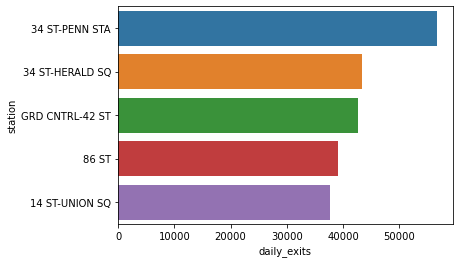

In [226]:
import seaborn as sns
plot_result = result[:5].copy().to_frame()
plot_result.rename(columns={'delta':'daily_exits'},inplace=True)

myplot = sns.barplot(x=plot_result.daily_exits, y=plot_result.index)

These are the 5 busiest stations in order : '34 ST-PENN STA', '34 ST-HERALD SQ', 'GRD CNTRL-42 ST', '86 ST' and '14 ST-UNION SQ'

In [199]:
plot_result = None

#### Notes

1. Incidentally, the station with the highest foot traffic, and the scond highest, are also included in results of    Sidenote above, where we theorized that a station with the most number of turnstiles is likely to have the   
   most traffic
2. This interesting tidbit about 34th Street in NYC, since our top 2 stations for exit foot traffic are on 
   34th street:<br>
   ``Several notable buildings are located directly along 34th Street, including the Empire State Building, Macy's 
   Herald Square, and Javits Center.``
   -- wikipedia.org (2021-08-08)

<!-- ### 2. Busiest times<a class="anchor" id="busy_time"></a> -->
<span style="font-size:1.5em"><b id="busy_time">2. Busiest Times</b></span> <a href="#top">[back to top]</a>

Lets check the busiest times for the first 5 stations:

#### 1. 34 ST-PENN STA

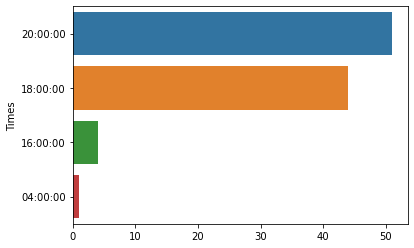

In [233]:
temp1=None
temp1 = temp[temp.station == '34 ST-PENN STA'].sort_values('delta', ascending=False)[:100].copy()
temp1['times'] = temp1.datetime.dt.time
plot_s = temp1.times.value_counts()
plot_s.index.name = 'Times'
plot1 = sns.barplot(y=plot_s.index, x=plot_s.values)

In [234]:
plot1 = None

Busiest times for the 2 stations on 34th street is 8pm, indicating that its probably a tourist spot/popular dining <br>spot. This may be a bit *inconvenient* for volunteers, but the volume of foot traffic would make it <u>totally <br>worth it</u>.
<br>
<br>Busiest time for Grand Central and 42nd street is at 9:00am, which indicates that its probably an office/co-working spot, and thus, may **not** be the best spot for volunteers, since people exiting would be rushing to office
<br>
<br>Busiest time for 86th street is 12:00pm, so it may be a popular lunch spot, and thus the <u>perfect place</u> to have volunteers at that time
<br>
<br>Busiest time for 14th street and union square is 5pm, indicating that it may be a transit station for people <br>getting off from work. This may be an <u>ok spot</u> to have volunteers, not the best, since such people would be 
<br>relaxed, but also the least attentive

<!-- ### Sidenote 2:<a class="anchor" id="sidenote_2"></a> -->
<span style="font-size:1.5em"><b id="sidenote_2">Sidenote 2:</b></span> <a href="#top">[back to top]</a>

Ok, I'm curious, why does TOMPKINSVILLE have such low exit traffic?

In [200]:
temp[temp.station == 'TOMPKINSVILLE'].exits.describe()

count     3773.000000
mean      9982.633448
std      22730.946782
min          0.000000
25%          2.000000
50%         12.000000
75%       4303.000000
max      65536.000000
Name: exits, dtype: float64

In [201]:
temp[temp.station == 'TOMPKINSVILLE'].exits.value_counts()

4303     539
3        539
12       539
2        539
0        539
65536    539
22       305
23       234
Name: exits, dtype: int64

In [202]:
temp[temp.station == 'TOMPKINSVILLE'].entries.value_counts()

654       170
262575    145
262600    124
262589     77
647        77
         ... 
649742      1
678418      1
678420      1
645666      1
59876       1
Name: entries, Length: 2027, dtype: int64

Very few unique exit values, compared to entry values, and a lot of them seem stuck at the same number, indicating a possible defect with the exit counter